In [16]:
###########################

In [18]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.image import resize
from IPython.display import Audio

In [20]:
# Define function to load and play audio
def play_audio(file_path, sr=44100):
    y, sr = librosa.load(file_path, sr=sr)
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.show()
    return Audio(data=y, rate=sr)

In [22]:
# Define function to plot mel spectrogram
def plot_melspectrogram(y, sr):
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()

In [24]:
# Define function to plot mel spectrogram in chunks
def plot_melspectrogram_chunks(y, sr, chunk_duration=4, overlap_duration=2):
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr
    num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
    
    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
        chunk = y[start:end]
        
        spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel Spectrogram - Chunk {i+1}")
        plt.tight_layout()
        plt.show()

In [26]:
# Load and preprocess audio data function
def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []
    
    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing:", class_name)
        
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                
                try:
                    audio_data, sample_rate = librosa.load(file_path, sr=None)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
                    continue
                
                chunk_duration = 4
                overlap_duration = 2
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate
                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
                
                for i in range(num_chunks):
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    chunk = audio_data[start:end]
                    
                    if len(chunk) < chunk_samples:
                        # Skip incomplete chunk
                        continue
                    
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                    
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    
    return np.array(data), np.array(labels)

In [28]:
# Usage example
data_dir = "C:/Users/adity/Downloads/Data/genres_original"
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


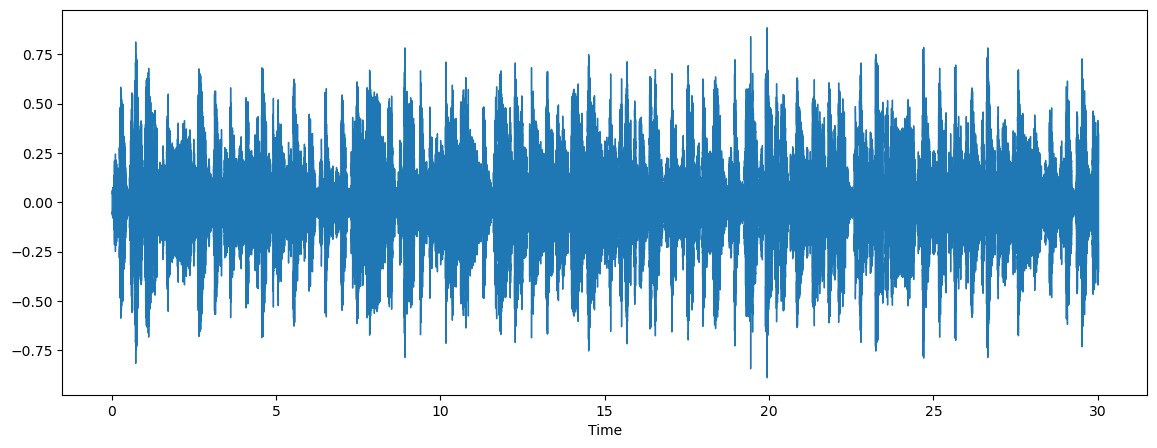

In [30]:
sample_audio = "C:/Users/adity/Downloads/Data/blues.00000.wav"
play_audio(sample_audio)


In [32]:
data, labels = load_and_preprocess_data(data_dir, classes)

Processing: blues
Processing: classical
Processing: country
Processing: disco
Processing: hiphop
Processing: jazz


C:\Users\adity\AppData\Local\Temp\ipykernel_11908\3585513236.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None)
C:\Users\adity\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading C:/Users/adity/Downloads/Data/genres_original\jazz\jazz.00054.wav: 
Processing: metal
Processing: pop
Processing: reggae
Processing: rock


In [34]:
data, labels = load_and_preprocess_data(data_dir, classes)
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Processing: blues
Processing: classical
Processing: country
Processing: disco
Processing: hiphop
Processing: jazz


C:\Users\adity\AppData\Local\Temp\ipykernel_11908\3585513236.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None)


Error loading C:/Users/adity/Downloads/Data/genres_original\jazz\jazz.00054.wav: 
Processing: metal
Processing: pop
Processing: reggae
Processing: rock
Data shape: (13977, 150, 150, 1)
Labels shape: (13977,)


In [47]:
# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels, num_classes=len(classes))

In [62]:
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import Audio
from tensorflow.keras.optimizers import Adam


In [53]:
# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [54]:
# Define CNN model for music genre classification
model = tf.keras.models.Sequential()
input_shape = X_train[0].shape
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units=1200, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(units=len(classes), activation='softmax'))


C:\Users\adity\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [55]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [66]:
training_history = model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 1044s 3s/step - accuracy: 0.1814 - loss: 2.1630 - val_accuracy: 0.4013 - val_loss: 1.6581
Epoch 2/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 583s 2s/step - accuracy: 0.4324 - loss: 1.5566 - val_accuracy: 0.5293 - val_loss: 1.3287
Epoch 3/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 485s 1s/step - accuracy: 0.5844 - loss: 1.1872 - val_accuracy: 0.6592 - val_loss: 0.9919
Epoch 4/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - accuracy: 0.6575 - loss: 1.0053 - val_accuracy: 0.6964 - val_loss: 0.9117
Epoch 5/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.7201 - loss: 0.8123 - val_accuracy: 0.7489 - val_loss: 0.7716
Epoch 6/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - accuracy: 0.7735 - loss: 0.6960 - val_accuracy: 0.7389 - val_loss: 0.7560
Epoch 7/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 437s 1s/step - accuracy: 0.7877 - loss: 0.6253 - val_accuracy: 0.7979 - val_loss: 0.5820
Epoch 8/30
350/350 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.8243 - loss: 0.5184 - val_acc

In [67]:
model.save("Trained_model_songs.keras")

In [68]:
with open('training_hist.json', 'w') as f:
    json.dump(training_history.history, f)

In [69]:
model = tf.keras.models.load_model("Trained_model_songs.keras")


In [70]:
with open("training_hist.json", 'r') as json_file:
    training_history_data = json.load(json_file)

In [71]:
# Evaluate model performance on training and validation data
train_loss, train_accuracy = model.evaluate(X_train, Y_train)
print("Training Loss:", train_loss, "Training Accuracy:", train_accuracy)

350/350 ━━━━━━━━━━━━━━━━━━━━ 120s 342ms/step - accuracy: 0.9954 - loss: 0.0171
Training Loss: 0.0185493603348732 Training Accuracy: 0.9952598214149475


In [72]:
val_loss, val_accuracy = model.evaluate(X_test, Y_test)
print("Validation Loss:", val_loss, "Validation Accuracy:", val_accuracy)

88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 339ms/step - accuracy: 0.9211 - loss: 0.3162
Validation Loss: 0.3226770758628845 Validation Accuracy: 0.9170243144035339


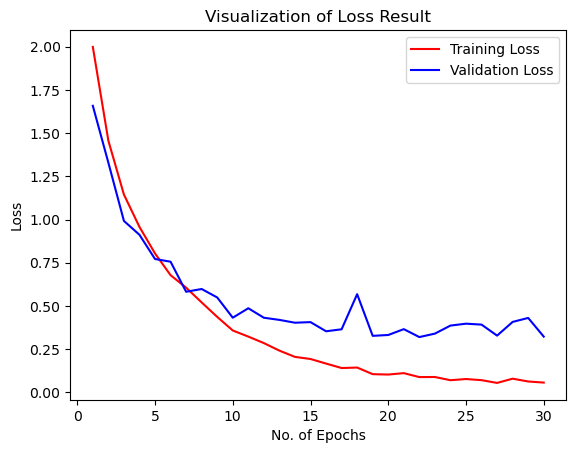

In [73]:
# Visualization of Loss
epochs = [i for i in range(1, 31)]
plt.plot(epochs, training_history_data['loss'], label="Training Loss", color='red')
plt.plot(epochs, training_history_data['val_loss'], label="Validation Loss", color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

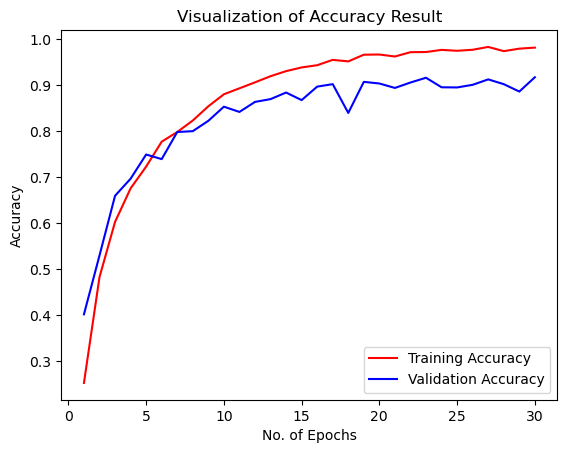

In [74]:
# Visualization of Accuracy
plt.plot(epochs, training_history_data['accuracy'], label="Training Accuracy", color='red')
plt.plot(epochs, training_history_data['val_accuracy'], label="Validation Accuracy", color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [75]:
# Make predictions and evaluate results
y_pred = model.predict(X_test)
predicted_categories = np.argmax(y_pred, axis=1)
true_categories = np.argmax(Y_test, axis=1)

88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 343ms/step


In [76]:
# Generate classification report and confusion matrix
print(classification_report(true_categories, predicted_categories, target_names=classes))
cm = confusion_matrix(true_categories, predicted_categories)

              precision    recall  f1-score   support

       blues       0.94      0.90      0.92       290
   classical       0.95      0.96      0.96       272
     country       0.84      0.84      0.84       296
       disco       0.89      0.97      0.93       263
      hiphop       0.97      0.95      0.96       294
        jazz       0.97      0.89      0.93       269
       metal       0.95      0.97      0.96       289
         pop       0.94      0.91      0.92       296
      reggae       0.92      0.91      0.92       257
        rock       0.81      0.88      0.84       270

    accuracy                           0.92      2796
   macro avg       0.92      0.92      0.92      2796
weighted avg       0.92      0.92      0.92      2796



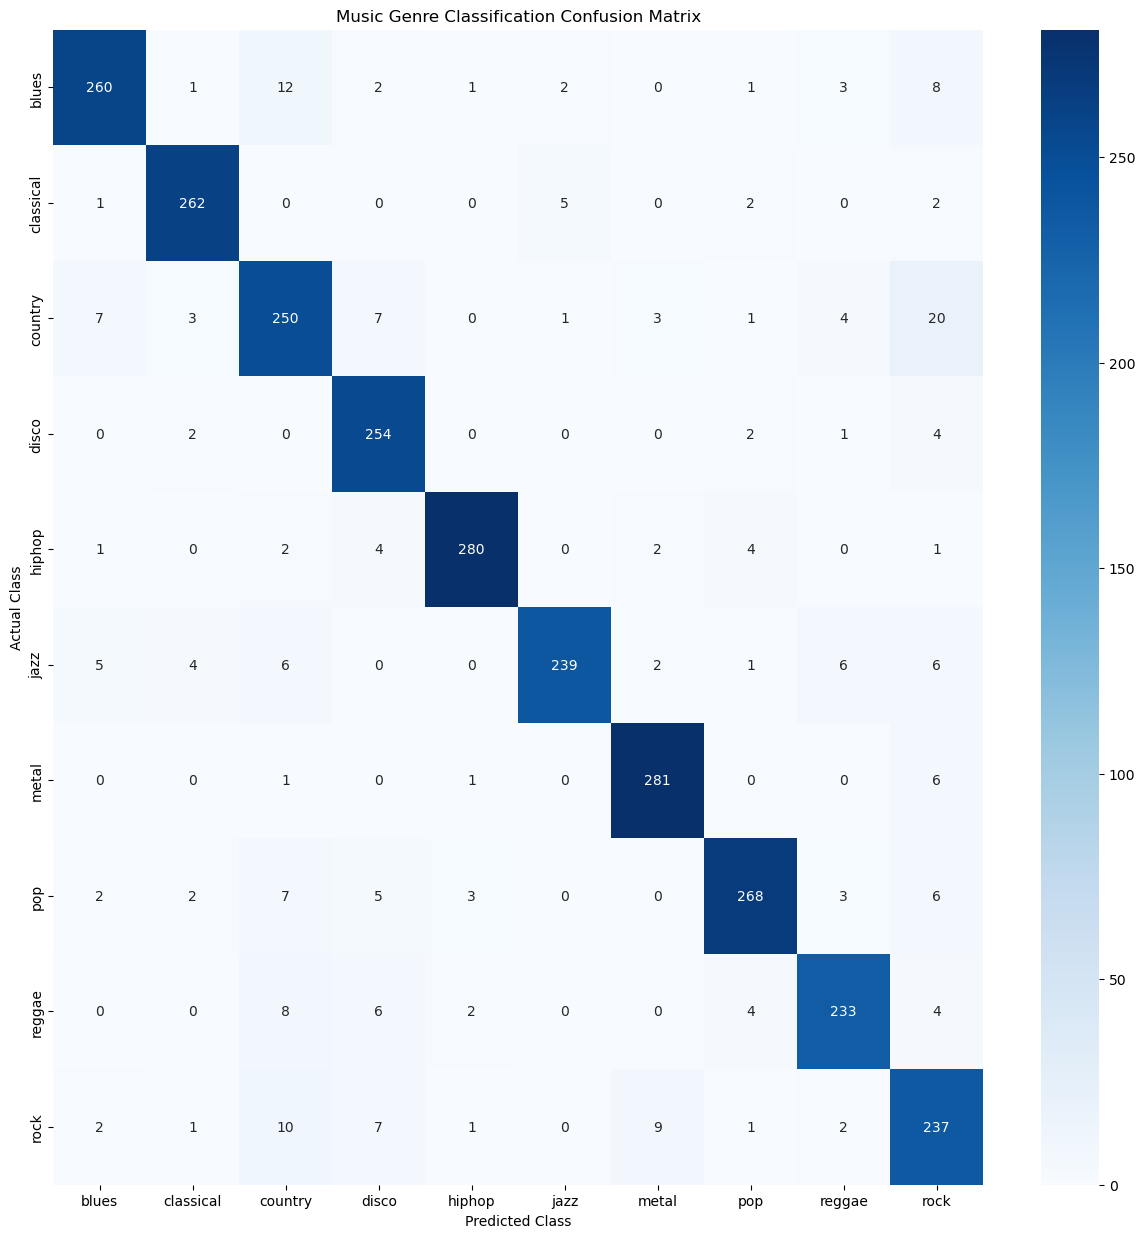

In [77]:
# Visualize the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Music Genre Classification Confusion Matrix")
plt.show()